In [25]:
import os
import time
import math
from datetime import datetime

import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as spt
from tqdm import tqdm
from functools import partial

import tensorflow as tf
import tensorflow_probability as tfp

import openturns as ot

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [4]:
def variance_weighted_result(means, stddevs):
    """ Computes weighted mean and stddev of given means and
        stddevs arrays, using Inverse-variance weighting
    """
    assert np.size(means) == np.size(stddevs)
    assert means.shape == stddevs.shape
    variance = 1./np.sum(1./stddevs**2, axis=-1)
    mean = np.sum(means/(stddevs**2), axis=-1)
    mean *= variance
    return mean, np.sqrt(variance)

In [5]:
def compute_stats(values):
    mean = sum(values) / len(values)
    var_unb = sum((v - mean) ** 2 for v in values) / (len(values) - 1)
    return mean, math.sqrt(var_unb)


def compute_stats_np(values):
    mean = np.mean(values)
    var_unb = np.sum((values - mean) ** 2) / (len(values) - 1)
    return mean, math.sqrt(var_unb)


def compute_stats_tf(values):
    mean = tf.reduce_mean(values, axis=-1)
    var_unb = tf.reduce_sum((values - mean) ** 2) / (len(values) - 1)
    return mean.numpy(), math.sqrt(var_unb)

In [6]:
NRUNS = 10

### Plot

In [7]:
ndims_lst = [2,4,6,8]
neval = int(1e2)

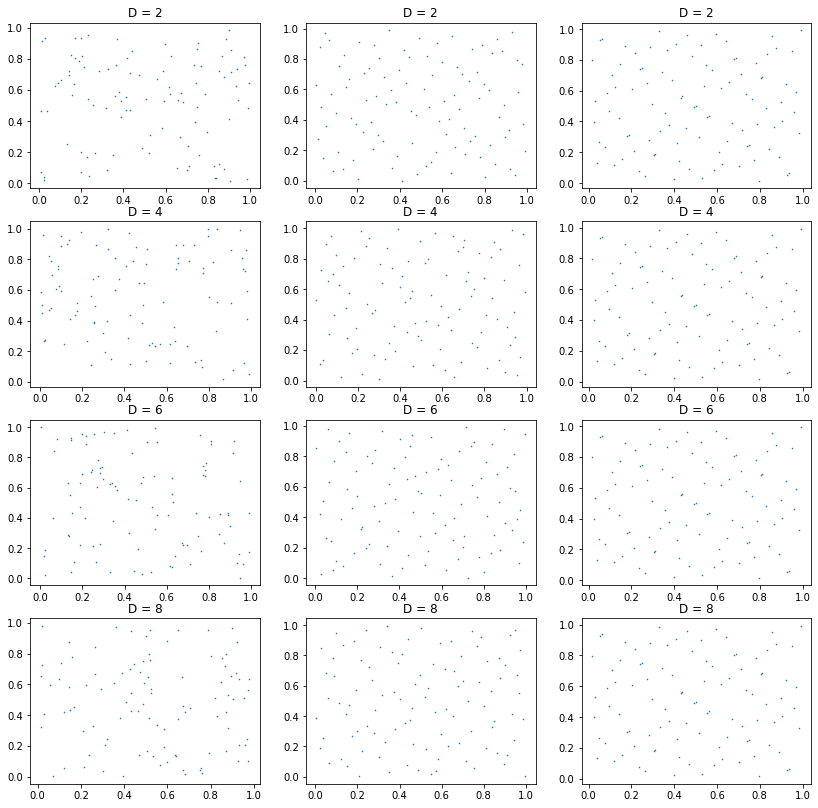

In [8]:
fig = plt.figure(figsize=(14,14))

i = 0
for ndims in ndims_lst:
    
    plot_data = tf.random.uniform(shape=(neval,ndims),
                                  minval=0,
                                  maxval=1,
                                  dtype=tf.float64,
                                  seed=123).numpy()[:, :2]
    ax = fig.add_subplot(len(ndims_lst),3,i+1)
    ax.scatter(plot_data[:, 0], plot_data[:, 1], s=.5, marker='*')
    ax.set_title(f'D = {ndims}')
    
    plot_data = tfp.mcmc.sample_halton_sequence(
        dim=ndims,
        num_results=neval,
        sequence_indices=None,
        dtype=tf.float64,
        randomized=True,
        seed=123,
        name=None
    ).numpy()[:, :2]
    ax = fig.add_subplot(len(ndims_lst),3,i+2)
    ax.scatter(plot_data[:, 0], plot_data[:, 1], s=.5, marker='*')
    ax.set_title(f'D = {ndims}')
    
    plot_data = tf.math.sobol_sample(
        dim=ndims,
        num_results=neval,
        skip=0,
        dtype=tf.dtypes.float64,
        name=None
    ).numpy()[:, :2]
    ax = fig.add_subplot(len(ndims_lst),3,i+3)
    ax.scatter(plot_data[:, 0], plot_data[:, 1], s=.5, marker='*')
    ax.set_title(f'D = {ndims}')
    
    i += 3


In [19]:
2 ** 7, 2 ** 10, 2 ** 13

(128, 1024, 8192)

In [20]:
neval_lst = list(map(int, (128, 1024, 8192)))
ndims = 2

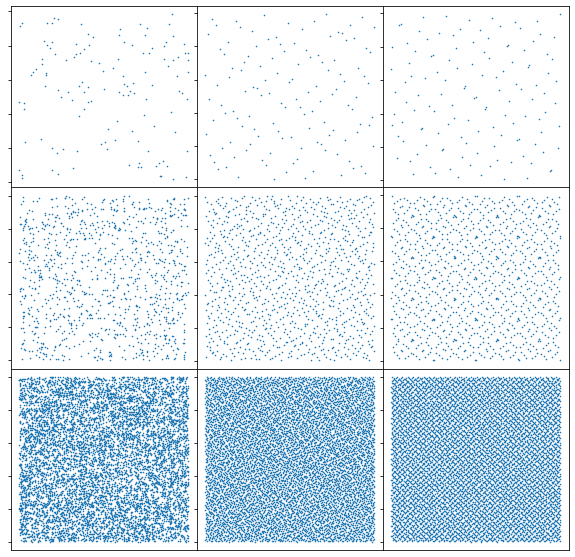

In [21]:
fig = plt.figure(figsize=(10,10))

i = 0
for neval in neval_lst:
    
    plot_data1 = tf.random.uniform(
        shape=(neval,ndims),
        minval=0,
        maxval=1,
        dtype=tf.float64,
        seed=123).numpy()[:, :2]
    ax = fig.add_subplot(len(neval_lst),3,i+1)
    ax.scatter(plot_data1[:, 0], plot_data1[:, 1], s=.5, marker='*')
    if i == 9:
        ax.set_xlabel(f'Uniform')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    ax.set_xticks([], minor=True)
    ax.set_yticks([], minor=True)
    # ax.axis('off')
    
    plot_data2 = tfp.mcmc.sample_halton_sequence(
        dim=ndims,
        num_results=neval,
        sequence_indices=None,
        dtype=tf.float64,
        randomized=True,
        seed=123,
        name=None
    ).numpy()[:, :2]
    ax = fig.add_subplot(len(neval_lst),3,i+2)
    ax.scatter(plot_data2[:, 0], plot_data2[:, 1], s=.5, marker='*')
    if i == 9:
        ax.set_xlabel(f'Halton')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False)
    ax.set_xticks([], minor=True)
    ax.set_yticks([], minor=True)
    # ax.axis('off')
    
    plot_data3 = tf.math.sobol_sample(
        dim=ndims,
        num_results=neval,
        skip=0,
        dtype=tf.dtypes.float64,
        name=None
    ).numpy()[:, :2]
    ax = fig.add_subplot(len(neval_lst),3,i+3)
    ax.scatter(plot_data3[:, 0], plot_data3[:, 1], s=.5, marker='*')
    if i == 9:
        ax.set_xlabel(f'Sobol')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False)
    ax.set_xticks([], minor=True)
    ax.set_yticks([], minor=True)
    # ax.axis('off')
    
    i += 3

plt.subplots_adjust(wspace=0, hspace=0)
# plt.xticks([])
# plt.yticks([])

In [22]:
fig.savefig('result/02_NaiveTensorflowLDSEager/uniform_halton_sobol_new.png', format='png')

In [23]:
plot_data1.shape, plot_data2.shape, plot_data3.shape

((8192, 2), (8192, 2), (8192, 2))

In [24]:
ot.LowDiscrepancySequence().computeStarDiscrepancy(plot_data1),\
    ot.LowDiscrepancySequence().computeStarDiscrepancy(plot_data2), \
    ot.LowDiscrepancySequence().computeStarDiscrepancy(plot_data3)

(0.012509031642110507, 0.0007539272604858982, 0.0004340261220932007)

In [28]:
spt.qmc.discrepancy(plot_data1, workers=4),\
    spt.qmc.discrepancy(plot_data2, workers=4),\
    spt.qmc.discrepancy(plot_data3, workers=4),\

(3.403612684560464e-05, 4.031196843001794e-08, 2.0278870138668026e-08)